<a href="https://colab.research.google.com/github/Kspel/Speldrick_2025/blob/main/Prose%20Tutorial/Image_Reduction_prose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# January 24
---

## Quickstart & Core Objects

*I pip installed prose which is a data base that can create astronomical pipelines. The pipeline in the tutorial creates a point spread function of an image.*

In [37]:
pip install 'prose @ git+https://github.com/lgrcia/prose'

  Cloning https://github.com/lgrcia/prose to /tmp/pip-install-1ul8al5z/prose_39e1f755f70e4df1b5439615da37089b
  Running command git clone --filter=blob:none --quiet https://github.com/lgrcia/prose /tmp/pip-install-1ul8al5z/prose_39e1f755f70e4df1b5439615da37089b
  Resolved https://github.com/lgrcia/prose to commit 020b6d4d57063a0757a4a944b930adf57c8cf148
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


*Then I loaded the test image.*

Telescope 'callisto' saved
Telescope 'io' saved
Telescope 'ganymede' saved
Telescope 'europa' saved
Telescope 'artemis' saved
Telescope 'trappist-south' saved
Telescope 'trappist-north' saved
Telescope 'saint-ex' saved
Telescope 'liverpool' saved
Telescope 'spirit' saved
A config file as been created in /root/.prose
downloading ballet model (~30Mb)


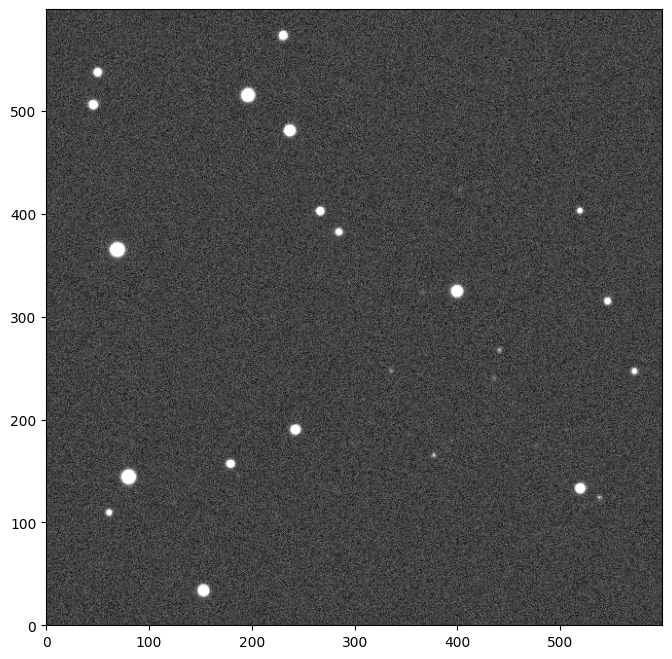

In [2]:
from prose import Sequence, blocks, example_image
import matplotlib.pyplot as plt

# getting the example image
image = example_image()
image.show()

*The next thing to do is to build a Sequence which contains a single Block.*

  0%|          | 0/1 [00:00<?, ?images/s]

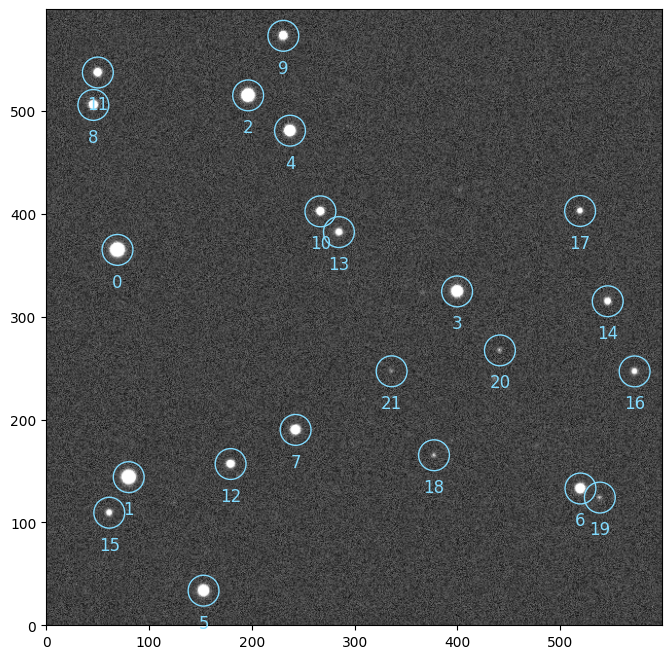

In [3]:
sequence = Sequence(
    [
        blocks.PointSourceDetection(),  # stars detection
        blocks.Cutouts(21),             # cutouts extraction
        blocks.MedianEPSF(),            # PSF building
        blocks.Moffat2D(),              # PSF modeling
    ]
)

sequence.run([image])

# plotting the detected stars
image.show()

*Then I can plot the results from the PSF and the modeling of the image.*

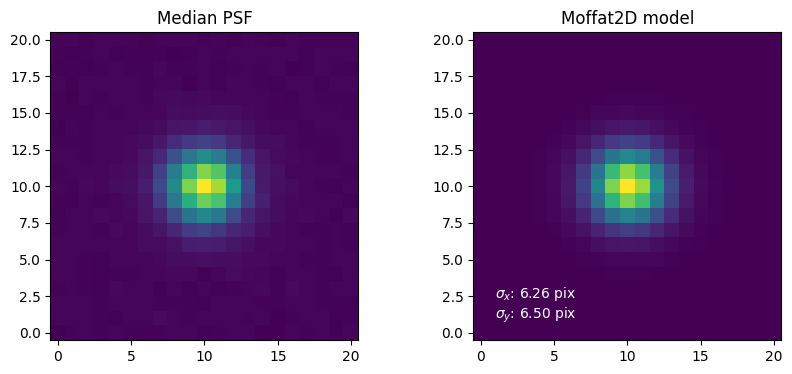

In [4]:
plt.figure(None, (10, 4))

# PSF building
plt.subplot(1, 2, 1, title="Median PSF")
plt.imshow(image.epsf.data, origin="lower")

# PSF modeling
params = image.epsf.params
model = image.epsf.model

plt.subplot(1, 2, 2, title=f"Moffat2D model")
plt.imshow(model(params), origin="lower")
_ = plt.text(
    1,
    1,
    f"$\sigma_x$: {params['sigma_x']:.2f} pix\n$\sigma_y$: {params['sigma_y']:.2f} pix",
    c="w",
)

*The three main objects for a pipeline in prose is: Image, Block, and Sequence. An image containsthe data and metadata. A block is a singular unit of precessing that is actiong on the image. A sequence is a sucession of block.*

In [5]:
from prose import Image, Block, Sequence
import numpy as np

np.random.seed(42)
images = [Image(data=np.random.rand(10, 10)) for i in range(5)]

In [6]:
class HelloWorld(Block):
    def run(self, image):
        image.mean = np.mean(image.data)
        print(f"Hello world (mean: {image.mean:.2f})")

In [7]:
sequence = Sequence(
    [
        HelloWorld(),
    ]
)

sequence.run(images)

  0%|          | 0/5 [00:00<?, ?images/s]

Hello world (mean: 0.47)
Hello world (mean: 0.50)
Hello world (mean: 0.52)
Hello world (mean: 0.49)
Hello world (mean: 0.52)


# January 28
---

##Tutorials

### Fits Manager

*The Fits Manager can be used to help sort the many disorganized image folders.*

In [8]:
from prose import FitsManager, Telescope
from prose import simulations

To show an example of what the Fits Manager can do, the tutorial uses fake data from two fake telescopes, A and B.

In [9]:
_ = Telescope(name="A", save=True)
_ = Telescope(name="B", save=True)

Telescope 'a' saved
Telescope 'b' saved


*The information is very disorganized and hard to manuver through.*

In [10]:
destination = "./fake_observations"
simulations.disorganised_folder(destination)

*Using Fits, we can organize the data with ease. Fits shows which telescope the data is from. It also shows the ID, filter, type, height, width, how many files is used and the date of the image.*

In [11]:
fm = FitsManager(destination)
fm

Parsing FITS:   0%|          | 0/28 [00:00<?, ?it/s]

date telescope filter   type target  width  height  files
id                                                                 
4   2025-02-07         B      b  light  prose     10      20      5
7   2025-02-07    Spirit          dark  prose     10      10      2
2   2025-02-07    Spirit      a  light  prose     10      10      5
6   2025-02-07    Spirit     ab  light  prose     10      10      5
1   2025-02-07    Spirit      b   flat  prose     10      10      2
5   2025-02-07    Spirit      b  light  prose     10      10      5
8   2025-02-07    Spirit      c   dark  prose     10      10      2
3   2025-02-07    Spirit      c   flat  prose     10      10      2

*You can search for the image using the ID.*

In [12]:
files = fm.observation_files(1)

/usr/local/lib/python3.11/dist-packages/prose/io/fitsmanager.py:537: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, axis=0).set_index(["id"])


date telescope filter  type target width height  exposure files
id                                                                       
1   2025-02-07    Spirit      b  flat  prose    10     10       1.0     2
7   2025-02-07    Spirit         dark  prose    10     10       1.0     2
8   2025-02-07    Spirit      c  dark  prose    10     10       8.0     2
1   2025-02-07    Spirit      b  flat  prose    10     10       1.0     2

*Fits Manager stores and sorts its information using keywords from the headers. The basic way to do this is by specifying the name of the telescope. The rest of the data gets sorted by default. If you want more detailed keywords, you can set them when you register the telescopes.*

###Images photometry

*Next we learn how to process a complete night of raw data from a telescope. We do this by builing a data reduction Sequence. We start by generating a light curve.*

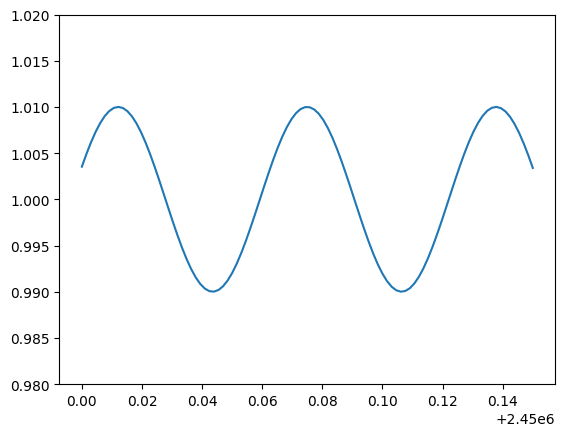

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from prose.simulations import simulate_observation

time = np.linspace(0, 0.15, 100) + 2450000
target_dflux = 1 + np.sin(time * 100) * 1e-2

plt.plot(time, target_dflux)
_ = plt.ylim(0.98, 1.02)

*Then we simulate the fits images that are associated with this target. This simulated comparison stars, their flux, and systematic noise.*

In [14]:
# so we have the same data
np.random.seed(40)

fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


*Now that we have that, we can see what's in the folder using Fits Manager.*

In [15]:
from prose import FitsManager

fm = FitsManager(fits_folder, depth=2) #Depth = 2 determines how far into the folder it looks
fm
#Depth = 0: Look only in the root fits_folder.
#Depth = 1: Look in the root folder and its immediate subdirectories.
#Depth = 2: Look in the root folder, its immediate subdirectories, and their subdirectories.

Parsing FITS:   0%|          | 0/106 [00:00<?, ?it/s]

date telescope filter   type target  width  height  files
id                                                                 
4   2025-02-07    Spirit          bias  prose    600     600      1
3   2025-02-07    Spirit          dark  prose    600     600      1
2   2025-02-07    Spirit      a   flat  prose    600     600      4
1   2025-02-07    Spirit      a  light  prose    600     600    100

*In order to perform the photometric extraction of fluxes on all the images, we have to use a reference image. From this image, we will extract the stars positions and the global full-width at half-maximum of the PSF.*

In [16]:
from prose import FITSImage

ref = FITSImage(fm.all_images[0])

*Then we can get started with building the sequence.*

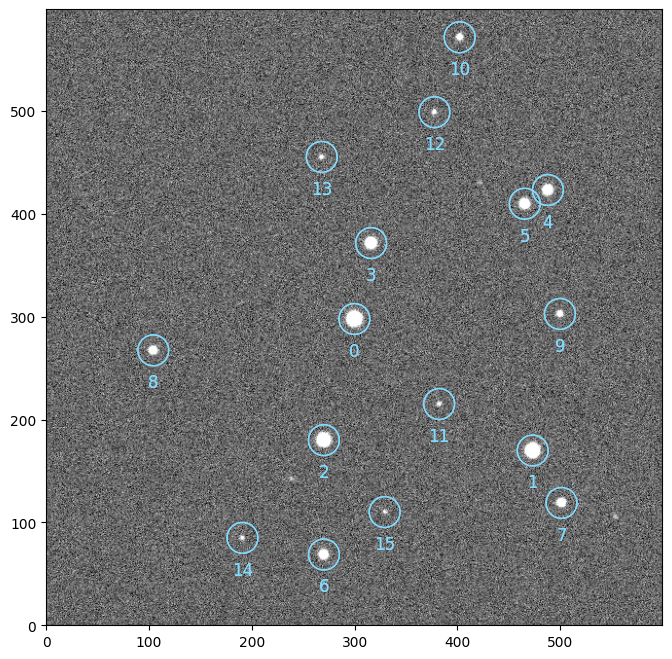

In [17]:
from prose import Sequence, blocks

calibration = Sequence(
    [
        blocks.Calibration(darks=fm.all_darks, bias=fm.all_bias, flats=fm.all_flats),
        blocks.Trim(),
        blocks.PointSourceDetection(),  # stars detection
        blocks.Cutouts(21),  # making stars cutouts
        blocks.MedianEPSF(),  # building PSF
        blocks.psf.Moffat2D(),  # modeling PSF
    ]
)

calibration.run(ref, show_progress=False)

ref.show()
ref.sources.plot()

*With the sequence created we can start extracting the photometry. In order to load a bunch of images without having to load them into the memory, we specify a loader to photometry.run. Though with this you can not access the individual image and its data.*

In [18]:
radii = np.linspace(0.2, 4, 30)

photometry = Sequence(
    [
        *calibration,  # calibration
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(radii=radii),  # aperture photometry
        blocks.AnnulusBackground(),  # local background estimate
        blocks.GetFluxes(),
    ]
)

photometry.run(fm.all_images, loader=FITSImage)

  0%|          | 0/100 [00:00<?, ?images/s]

*The GetFluxes block provide a way to retrieve the fluxes computed by the AperturePhotometry minus the background estimated with AnnulusBackground*

In [19]:
raw_fluxes = photometry[-1].fluxes

*We can then produce the differential photometry with autodiff*

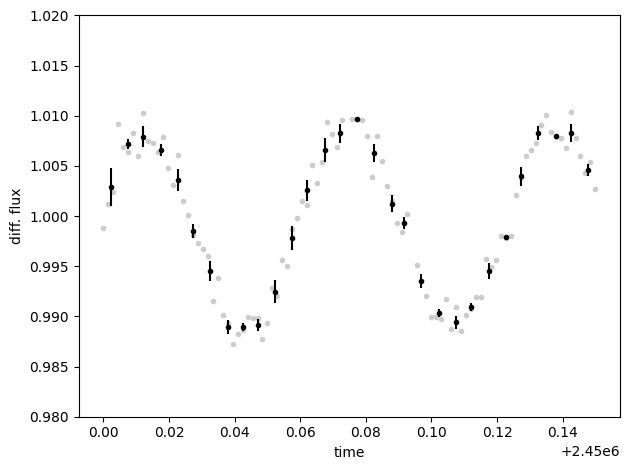

In [20]:
# picking target
raw_fluxes.target = 0

# good practice
raw_fluxes = raw_fluxes.sigma_clipping_data(bkg=3)

# differential photometry
diff_fluxes = raw_fluxes.autodiff()
diff_fluxes.plot()
diff_fluxes.bin(0.005, True).errorbar()

plt.ylim(0.98, 1.02)
plt.xlabel("time")
plt.ylabel("diff. flux")
plt.tight_layout()

###Custom Block

*Here is a more detailed example on how to create a custom block by subclassing the Block class (and make it user and community-friendly). The purpose of the Block we will create is to correct for image vignetting*

In [21]:
from prose import example_image

image = example_image(seed=4)

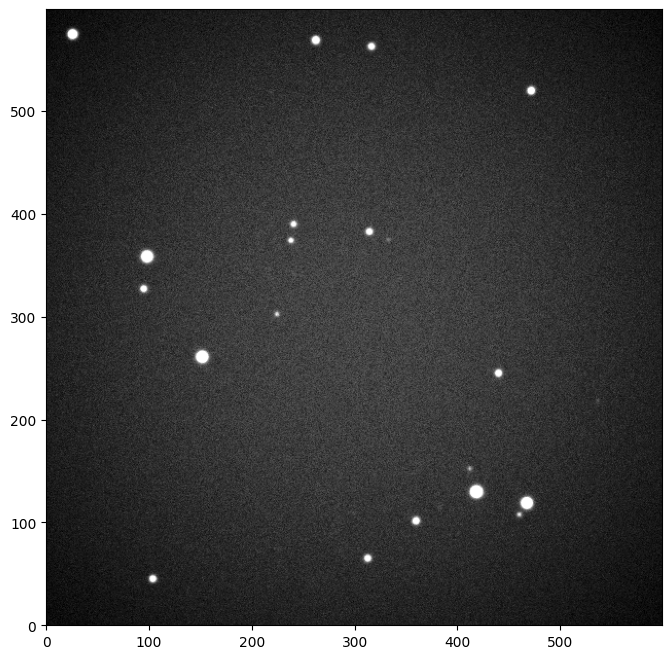

In [22]:
import numpy as np


# vignette function
def gaussian2D(XY, xy, sigma, amplitude=1):
    X, Y = XY
    x, y = xy
    return (
        amplitude
        * np.exp(-((X - x) ** 2 / sigma**2) - ((Y - y) ** 2 / sigma**2)) ** 3
    )


# vignetting the image data
XY = np.indices(image.shape)
vignette = gaussian2D(XY, (np.array(image.shape) / 2), 1000)
image.data *= vignette
image.show()

*The method to correct for the vignetting is simple:*

*We build a sigma-clipped version of the image to exclude bright (stars) pixels (iteratively)*

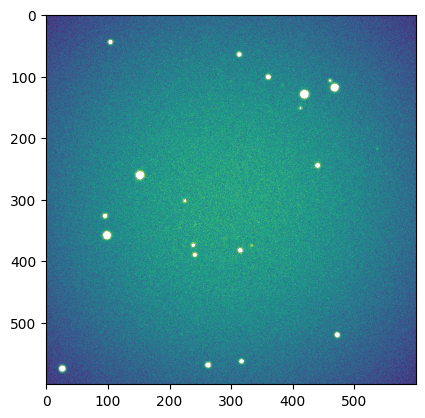

In [23]:
import matplotlib.pyplot as plt

sg_image = image.data.copy()

sg_image = image.data.copy()
mask = np.ones_like(sg_image).astype(bool)
for _ in range(5):
    mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5 * np.std(sg_image[mask])
sg_image[~mask] = np.nan

plt.imshow(sg_image)

*We fit the vignette model to the sigma clipped data.*

In [24]:
from scipy.optimize import minimize

center = np.array(image.shape) / 2


def model(p):
    a, s = p
    return a * gaussian2D(XY, center, s)


def nll(p, sg_image):
    _model = model(p)
    return np.log(np.nansum((_model - sg_image) ** 2))


x0 = [5000, image.shape[0]]
sol = minimize(nll, x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,))

*We correct the image from the fitted vignette.*

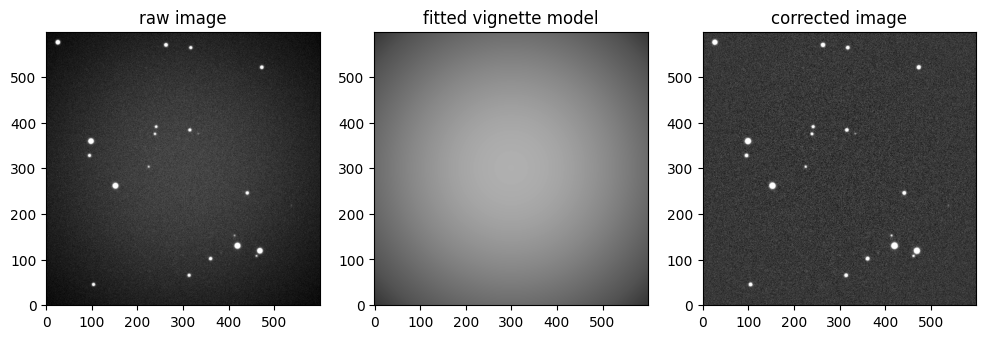

In [25]:
corrected_image = image.copy()
corrected_image.data -= model(sol.x)

# plotting
# --------
plt.figure(None, (12, 6))

ax1 = plt.subplot(131, title="raw image")
image.show(ax=ax1)

ax2 = plt.subplot(132, title="fitted vignette model")
plt.imshow(
    model(sol.x),
    origin="lower",
    cmap="Greys_r",
    vmin=np.nanmin(sg_image),
    vmax=np.nanmax(sg_image),
)

ax3 = plt.subplot(133, title="corrected image")
_ = corrected_image.show(ax=ax3)

*Now we can create a Block. There are two methods: the simple way and the user-friendly way. The simpliest way is to subclass the Block class, and copy-paste the code above into its run(self, image) method, which will be called on each Image.*

In [26]:
#Simple Way
from prose import Block


class SimpleVignettingCorr(Block):
    def __init__(self, **kwargs):
        super().__init__(self, **kwargs)

    def run(self, image):
        # 1. Sigma clipping
        sg_image = image.data.copy()
        mask = np.ones_like(sg_image).astype(bool)
        for _ in range(5):
            mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5 * np.std(
                sg_image[mask]
            )
        sg_image[~mask] = np.nan

        XY = np.indices(image.shape)
        center = np.array(image.shape) / 2

        # 2. Fitting the model
        def model(p):
            a, s = p
            return a * gaussian2D(XY, center, s)

        def nll(p, sg_image):
            _model = model(p)
            return np.log(np.nansum((_model - sg_image) ** 2))

        x0 = [5000, image.shape[0]]
        sol = minimize(
            nll, x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,)
        )

        # correction
        image.data -= model(sol.x)

*Then apply it to the Data.*

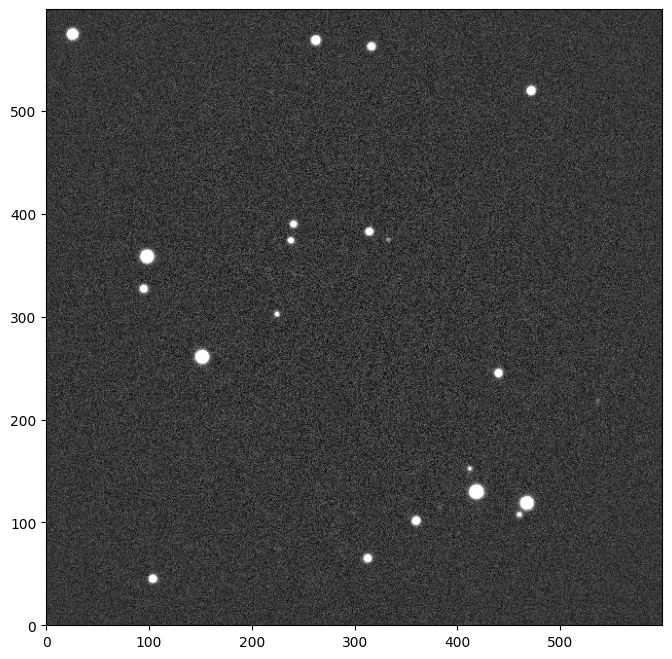

In [27]:
corrected_image = SimpleVignettingCorr()(image)
_ = corrected_image.show()

*SimpleVignettingCorr is not optimized which the User-friendly way cleans up and fixes.*

In [28]:
class BetterVignettingCorr(Block):
    # allowing for a reference image to be provided
    def __init__(self, reference=None, **kwargs):
        super().__init__(self, **kwargs)

        # to avoid re-computing it for every new image
        self.XY = None
        self.center = None

        # to save last optimized parameters
        self.x0 = None

        # pre-computing parameters if reference provided
        if reference is not None:
            self.XY = np.indices(reference.shape)
            self.center = np.array(reference.shape) / 2
            self.x0 = [5000, reference.shape[0]]

    @staticmethod
    def sigma_clip(data, n=5, sigma=5):
        sg_image = data.copy()
        mask = np.ones_like(sg_image).astype(bool)
        for _ in range(5):
            mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5 * np.std(
                sg_image[mask]
            )
        sg_image[~mask] = np.nan
        return sg_image

    def model(self, p):
        a, s = p
        return a * gaussian2D(self.XY, self.center, s)

    def chi(self, p, sg_image):
        model = self.model(p)
        return np.nansum((model - sg_image) ** 2)

    def run(self, image):
        # sigma clipping
        sg_image = self.sigma_clip(image.data)

        # if no reference, using first image to initialize parameters
        if self.x0 is None:
            self.x0 = [5000, image.shape[0]]
        if self.XY is None:
            self.XY = np.indices(image.shape)
            self.center = np.array(image.shape) / 2

        sol = minimize(
            self.chi,
            self.x0,
            bounds=((0, np.nanmax(sg_image)), (0, 2000)),
            args=(sg_image,),
        )
        self.x0 = sol.x  # keeping optimized parameters as first guess for next image

        # correction
        image.data -= model(sol.x)

*Then apply it to the data.*

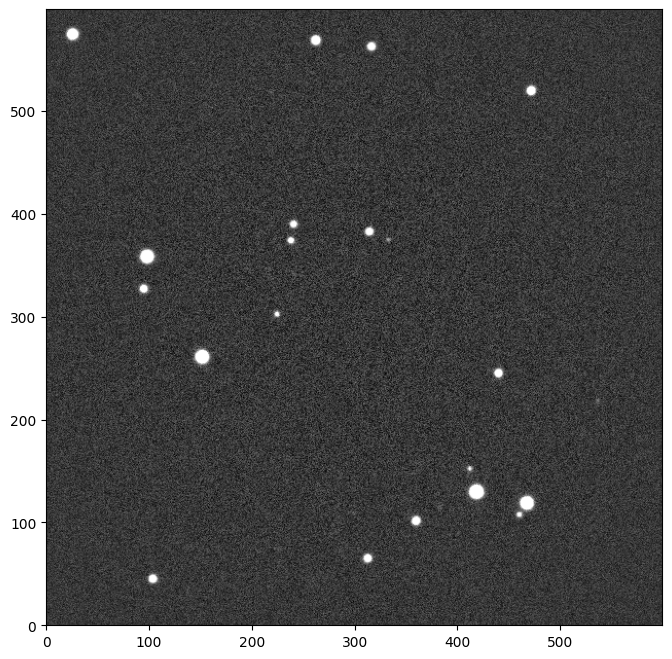

In [29]:
corrected_image = BetterVignettingCorr()(image)
_ = corrected_image.show()

*In instances where your work gets published. There is an acknowlegment section that is still being created in the book.*

###Catalogs & Plate solving

*It is often required to match your detected stars with a catalog. Let’s load an example image (from an archive like SDSS) and see how to make queries from a catalog*

INFO Querying https://archive.stsci.edu/cgi-bin/dss_form


/usr/local/lib/python3.11/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


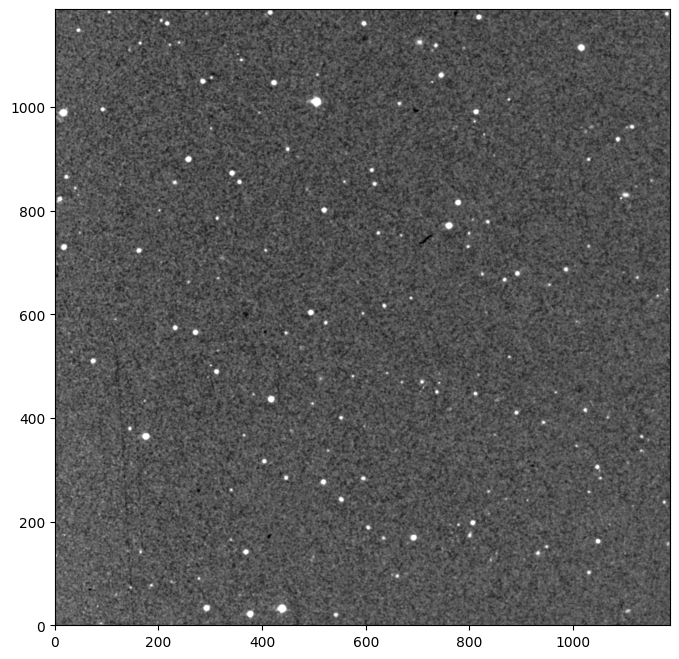

In [30]:
from prose.archive import sdss_image

# an image of TRAPPIST-1
image = sdss_image(("23 06 29.3684", "-05 02 29.0373"), (20, 20))
image.show()

*We can check if the image is plate solved by:*

In [31]:
image.plate_solved

True

#January 30
---

*We can also query a catalog. To do this we use a catalog block from the prose.blocks.catalogs module.*



In [32]:
from prose.blocks import catalogs

image = catalogs.GaiaCatalog(mode="replace")(image)

# visualizing the catalog stars
image.show()

AttributeError: [GaiaCatalog] Image must have sources (0 found)

*We can create an overlay with labels.*

In [ ]:
# show cutout around 13-th source
cutout = image.cutout(13, 300, reset_index=False)
cutout.show()
cutout.plot_catalog("gaia", label=True, color="w")

*We see here that the Image.sources (plotted by default with image.show) are set to the queried stars. If instead you want to cross-match the queried stars to already existing Image.sources, use catalogs.GaiaCatalog(mode='crossmatch'). This way the index of the Image.sources will be the same as the index in the catalog. The full catalogs can be found with:*

In [ ]:
image.catalogs["gaia"]

###Plate solving

*To plate solve an image we can use the following sequence.*

In [ ]:
from prose import Sequence, blocks

plate = Sequence(
    [
        blocks.detection.PointSourceDetection(n=30),
        blocks.catalogs.PlateSolve(debug=True),
    ]
)

plate.run(image, show_progress=False)

*Seeing the markers on the stars (only with debug=True) in the image shows that the plate solving was successful.
PlateSolve is slow so it is not recommended to use this block in a sequence with more than 5 images. Instead you can pass a plate-solved ref_image to this block so that catalog stars are queried only once*

#Note: The previous 4 blocks of code do not work because Gaia was shut down on January 15, 2025.

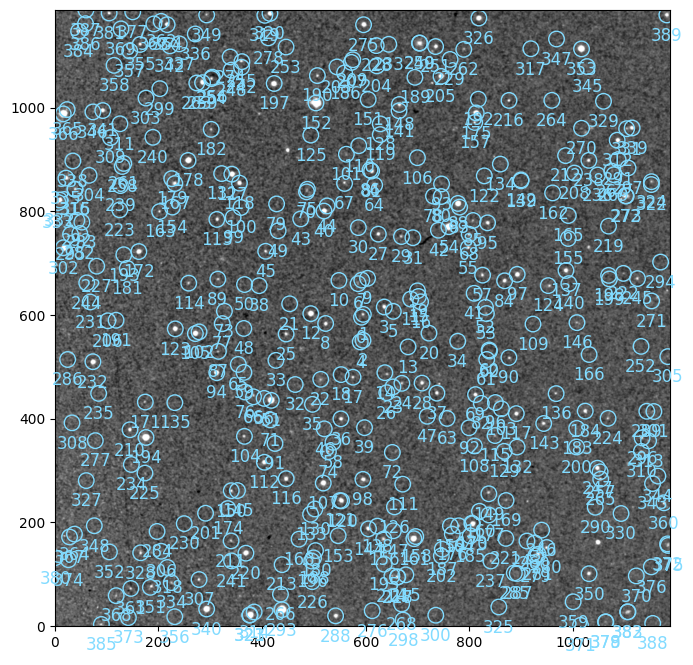

In [52]:
from prose.blocks import catalogs

image = catalogs.TESSCatalog(mode="replace")(image)

# visualizing the catalog stars
image.show()

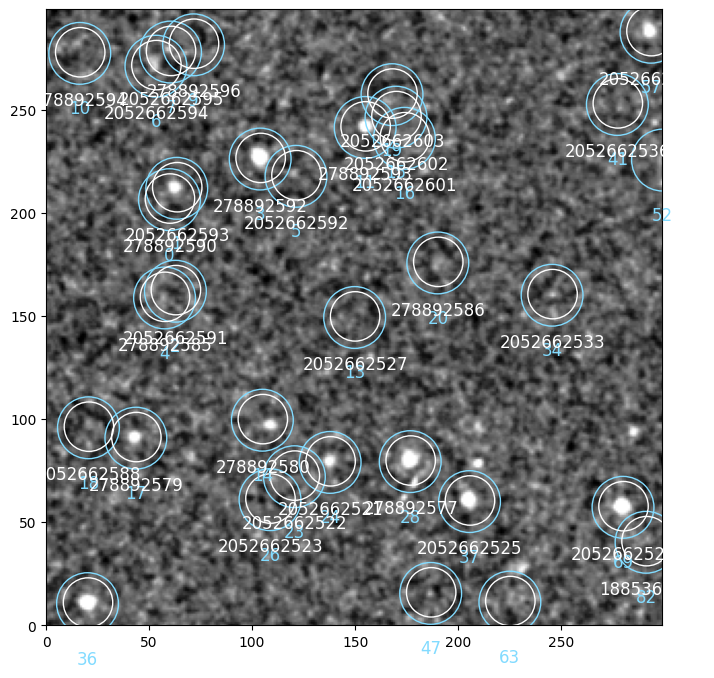

In [53]:
# show cutout around 13-th source
cutout = image.cutout(13, 300, reset_index=False)
cutout.show()
cutout.plot_catalog("tess", label=True, color="w")

In [54]:
image.catalogs["tess"]

index          id          ra       dec        pmRA      pmDEC     Tmag  \
0        0   278892590  346.622497 -5.041343  901.000000 -492.00000  13.8529   
1        1  2052662593  346.621492 -5.039808   -8.220020   -5.08612  17.9745   
2        2  2052662591  346.621722 -5.053785   19.669200   -7.42345  19.1984   
3        3   278892592  346.610083 -5.035869    0.852974   -9.77651  15.6419   
4        4   278892585  346.623215 -5.054692   -3.066070   -3.95488  18.3070   
..     ...         ...         ...       ...         ...        ...      ...   
385    540  2052662326  346.764432 -5.206762   -6.012260  -11.38340  19.0018   
386    544  2052662903  346.771859 -4.882256  -25.261400  -15.93380  18.8301   
387    568   278894861  346.771611 -4.874872   14.229500   -2.33986  17.4905   
388    592  2052662488  346.464808 -5.207269  -13.068200   -6.24344  19.1377   
389    610   248054972  346.456071 -4.878633   -2.011200   -4.70151  16.9021   

    objType  typeSrc   version  ...       e_Dec     RA_orig  Dec_orig  \
0      STAR  tmgaia2  20190415  ...  124.000035  346.626392 -5.043462   
1      STAR    gaia2  20190415  ...    5.426640  346.621457 -5.039830   
2      STAR    gaia2  20190415  ...   26.388680  346.621807 -5.053817   
3      STAR  tmgaia2  20190415  ...    1.823612  346.610086 -5.035911   
4      STAR  tmgaia2  20190415  ...   11.436172  346.623202 -5.054709   
..      ...      ...       ...  ...         ...         ...       ...   
385    STAR    gaia2  20190415  ...   14.594018  346.764406 -5.206811   
386    STAR    gaia2  20190415  ...   16.870972  346.771750 -4.882324   
387    STAR  tmgaia2  20190415  ...    6.161418  346.771673 -4.874882   
388    STAR    gaia2  20190415  ...   15.361884  346.464752 -5.207296   
389    STAR  tmgaia2  20190415  ...    2.859821  346.456063 -4.878653   

    e_RA_orig e_Dec_orig raddflag wdflag   dstArcSec            x            y  
0    0.108955   0.092806        1      0    1.795642   591.871530   595.664469  
1    0.199327   0.188286        1      0    6.014264   595.423795   601.164826  
2    0.967337   0.680088        1      0   44.595682   594.779246   551.215690  
3    0.071476   0.062621        1      0   47.147617   635.906565   615.382487  
4    0.439182   0.294423        1      0   48.047755   589.488390   547.955633  
..        ...        ...      ...    ...         ...          ...          ...  
385  0.424249   0.359397        1      0  784.350059    89.875877     2.673859  
386  0.719228   0.591786        1      0  785.563627    59.209235  1162.250101  
387  0.277154   0.213550        1      0  804.564761    59.994526  1188.641201  
388  0.554414   0.540780        1      0  821.120009  1153.967635     4.675339  
389  0.114254   0.090103        1      0  835.166054  1181.235225  1179.109519  

[390 rows x 128 columns]

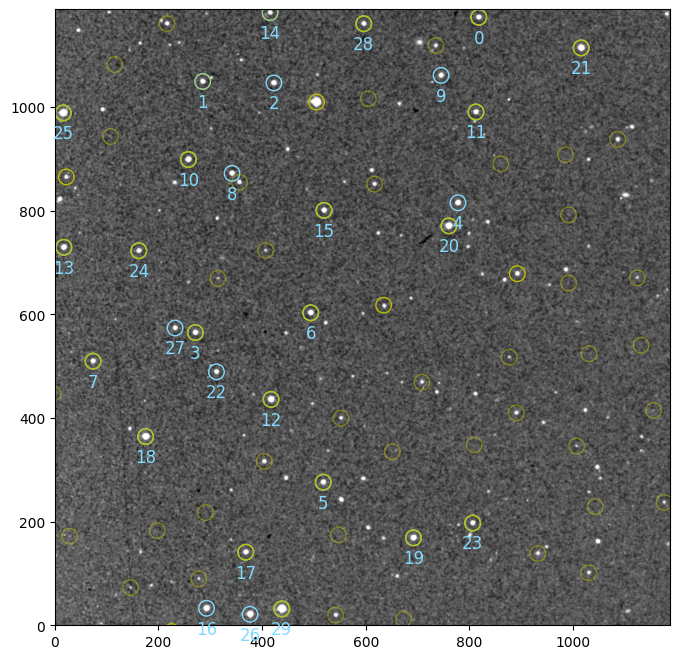

In [55]:
from prose import Sequence, blocks

plate = Sequence(
    [
        blocks.detection.PointSourceDetection(n=30),
        blocks.catalogs.PlateSolve(debug=True),
    ]
)

plate.run(image, show_progress=False)

#I was able to correst some errors by replaceing "gaia" with "tess", but some parts of the code have many subcodes that involve gaia. Update at 3:45 : I have no idea how or why but the code that was originally pulling from a plate solve code that was using gaia is working despite Gaia no longer being avaliable. I do not know if the code was updated to use TESS or if something else happened.

#February 4

##Case Studies

###Exoplanet Transit

*First we downloaded the files we needed into our google drives. Now we have to make sure colab can pull from the drive.For this observation, the headers of the calibration images do not contain information about the nature of each image, bias, dark or flat. We will then retrieve our images by hand (where usually we would employ a FitsManager object)*

In [41]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [49]:
from glob import glob
from pathlib import Path

folder = Path("/content/drive/MyDrive/WAPS-12 b")

darks = glob(str(folder / "Darks/*.fit"))
bias = glob(str(folder / "Bias/*.fit"))
flats = glob(str(folder / "Flats/*.fit"))
sciences = sorted(glob(str(folder / "ScienceImages/*.fit")))

*What follows is the full reduction sequences, including the selection of a reference image to align sources and scale apertures on. More details are provided in the basic Photometry tutorial*

In [50]:
import numpy as np
from prose import FITSImage, Sequence, blocks

# reference is middle image
ref = FITSImage(sciences[len(sciences) // 2])

calibration = Sequence(
    [
        blocks.Calibration(darks=darks, bias=bias, flats=flats),
        blocks.Trim(),
        blocks.PointSourceDetection(n=40),  # stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Moffat2D(),  # modeling EPSF
    ]
)

calibration.run(ref, show_progress=False)

photometry = Sequence(
    [
        calibration[0],  # calibration block (same as above)
        blocks.PointSourceDetection(n=12, minor_length=8),  # fewer stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

photometry.run(sciences)

  0%|          | 0/336 [00:00<?, ?images/s]

*we can check the total processing time of each block.*

In [56]:
photometry

╒═════════╤════════╤═══════════════════════╤════════════════╕
│   index │ name   │ type                  │ processing     │
╞═════════╪════════╪═══════════════════════╪════════════════╡
│       0 │        │ Calibration           │ 5.117 s (4%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       1 │        │ PointSourceDetection  │ 52.397 s (36%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       2 │        │ Cutouts               │ 5.824 s (4%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       3 │        │ MedianEPSF            │ 0.438 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       4 │        │ Gaussian2D            │ 13.851 s (10%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       5 │        │ ComputeTransformTwirl │ 2.003 s (1%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       6 │        │ AlignReferenceSources │ 0.690 s (0%)   │
├───────

*Now that the photometry has been extracted, let’s focus on our target and produce a differential light curve for it. All fluxes have been saved in the GetFluxes block, in a Fluxes object. We can check the reference image, on which all images sources have been aligned, and pick our target*

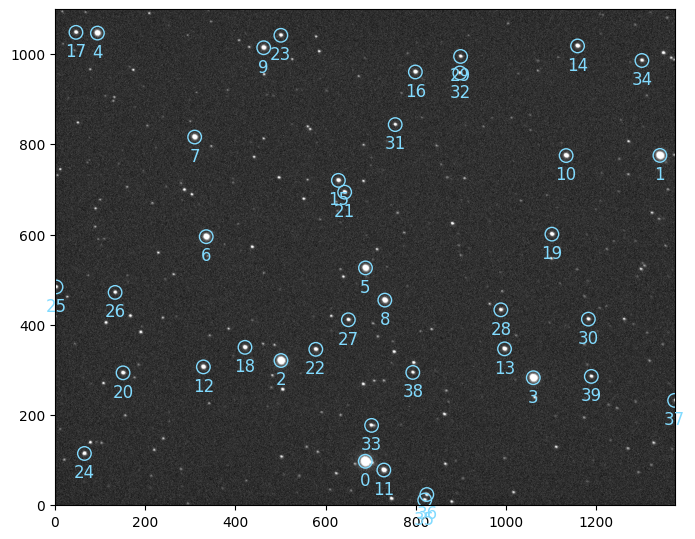

In [57]:
from prose import Fluxes

fluxes: Fluxes = photometry[-1].fluxes
ref.show()

*set this target (source 6) in the Fluxes object and proceed with automatic differential photometry And here is our planetary transit. To validate the differential photometry and the automatic choice of comparison stars, we can plot their light curves along the target light curve,*

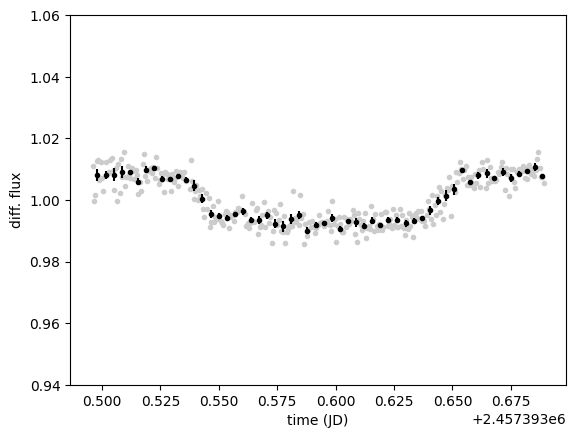

In [58]:
import matplotlib.pyplot as plt

fluxes.target = 6

# a bit of cleaning
nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping

# differential photometry
diff = fluxes.autodiff()

# plotting
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux", ylim=(0.94, 1.06))
diff.plot()
diff.bin(5 / 60 / 24, estimate_error=True).errorbar()

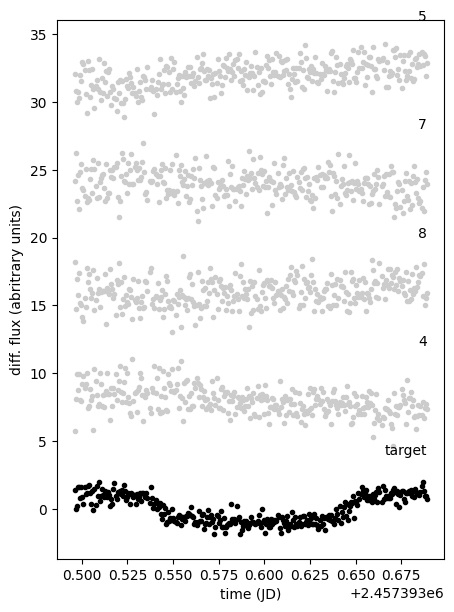

In [59]:
plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux (abritrary units)")


# plotting only the first five comparisons
for j, i in enumerate([diff.target, *diff.comparisons[0:5]]):
    y = diff.fluxes[diff.aperture, i].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * j
    plt.text(
        diff.time.max(), np.mean(y) + 4, i if i != diff.target else "target", ha="right"
    )
    plt.plot(diff.time, y, ".", c="0.8" if i != diff.target else "k")

*To help modeling the light curve, some explanatory measurements have been stored in*

In [60]:
diff.dataframe

bkg   airmass        dx        dy      fwhm          time  \
0    261.908217  1.878414 -0.314490  0.566460  4.823861  2.457393e+06   
1    263.309264  1.870291 -1.088033  0.466066  4.473182  2.457393e+06   
2    261.166625  1.862163 -0.868474  0.423316  4.369237  2.457393e+06   
3    252.933837  1.854302 -0.953985  0.551378  4.677914  2.457393e+06   
4    252.841191  1.846374 -1.025708  0.448884  4.735866  2.457393e+06   
..          ...       ...       ...       ...       ...           ...   
327  157.205040  1.013443  1.007175  0.613441  4.130941  2.457394e+06   
328  157.248958  1.013356  1.577194  0.623359  4.012928  2.457394e+06   
329  156.650647  1.013278  0.737424  0.519273  4.491135  2.457394e+06   
330  156.423297  1.013210  0.700936  0.711975  4.576201  2.457394e+06   
331  157.131704  1.013150  0.977755  0.784270  4.015619  2.457394e+06   

         flux  
0    1.011125  
1    0.999756  
2    1.001615  
3    1.012742  
4    1.012823  
..        ...  
327  1.015685  
328  1.010365  
329  1.007430  
330  1.007304  
331  1.005600  

[332 rows x 7 columns]

*that we can plot to check for any correlation with the differential flux*

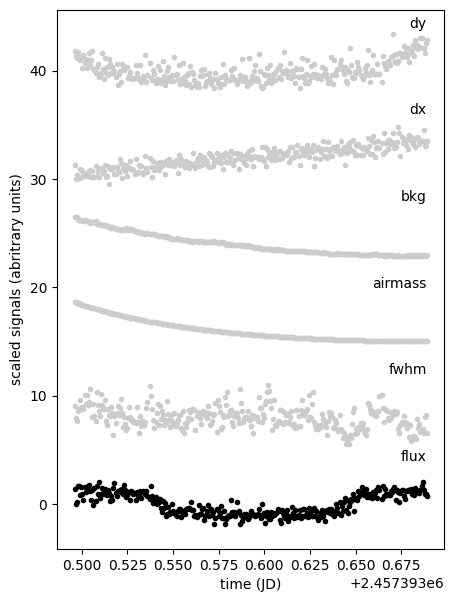

In [61]:
plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
    y = diff.df[name].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * i
    plt.text(diff.time.max(), np.mean(y) + 4, name, ha="right")
    plt.plot(diff.time, y, ".", c="0.8" if name != "flux" else "k")

*For those in a hurry, the photometry sequence can be made parallel. The SequenceParallel class is a subclass of Sequence that allows to run blocks in parallel. This object takes two lists of blocks. The first sequence of blocks is run for each image on a different CPU core, the second is run sequentially and must contain all blocks that retain data and are slower to move between CPU cores.*

In [62]:
from prose.core.sequence import SequenceParallel

faster_photometry = SequenceParallel(
    [
        blocks.Calibration(darks=darks, bias=bias, flats=flats, shared=True),
        blocks.PointSourceDetection(
            n=12, minor_length=8
        ),  # stars detection for alignment
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # align sources
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.Del("data", "sources", "cutouts"),  # (optional) reduce overhead
    ],
    [
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ],
)

faster_photometry.run(sciences)

  0%|          | 0/336 [00:00<?, ?images/s]